# Imports

In [100]:
import numpy as np
import xarray as xr
import scipy.io as io
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as mticker
import scipy
from scipy.stats import f
from scipy import signal
from scipy.optimize import curve_fit

# This code solves the energy balance model used in Roe et al. (Nat. Geosci., 2015)
# The model operates in climatology mode
# You can specify:-
# the insolation Q0
# the OLR parameters, A0,B0
# the diffusivity, D
# albedo of ocean and ice
# whether you diffuse moist static energy, or just sensible heat

# Constants and Parameters

## Simulation parameters

In [323]:
## Whether to save output to NetCDF file
save_output = True

## How often to save otuputs
save_frequency = 'monthly' # options are 'monthly', 'biweekly', or 'weekly'

## Noise parameters
noise_color = 'red' # options are 'no', 'white', or 'red'
noise_amplitude = 10 # units of W m^-2
noise_seed = 0
# red_noise_autocorrelation = 0.95 
# red_noise_e_folding_time = 1/(4*24*365) # e-folding time of 15 minutes
# red_noise_e_folding_time = 1/(1*24*365) # e-folding time of 1 hour
red_noise_e_folding_time = 12*month_step
# red_noise_e_folding_time = 1/100

## Level of statistical significance for regional variability
p_critical = 0.95

# How to modify the solar insolation (basic_state, warmed, or cooled')
climatological_forcing = {
    'basic_state':0,
    'warmed':4,
    'cooled':-4
}

climatology = 'warmed'

## Temporal Parameters

In [324]:
#time step in fraction of year
# delt=1./500000

# 15-minute time steps
time_step = 1/(4*24*365)
year_step = int(1/time_step)  

n_years = 300

n_iterations = int(n_years*(1/time_step))

# Number of iterations per month
month_step = year_step//12

# Number of months in the simulation
n_months = n_iterations//month_step

# Number of iterations per save
if save_frequency == 'yearly':
    save_step = year_step # save once a year - for very long simulations
elif save_frequency == 'monthly':
    save_step = month_step # save every month
elif save_frequency == 'biweekly':
    save_step = month_step//2 # save every 2 weeks
elif save_frequency == 'weekly':
    save_step = month_step//4 # save weekly

# Number of iterations that will be saved
n_saves = n_iterations//save_step

## Spatial parameters

In [325]:
# Specify number of longitude points
n_longitude=101

# Gerard's way of defining sin(latitude)
space_step = 2.0/n_longitude
sine_latitude = np.arange(-1.0+space_step/2,1.0,space_step)

# My way of defining sin(latitude)
# sine_latitude = np.linspace(-1, 1, n_longitude)

# Calculate latitude from sin(latitude)
latitude = np.arcsin(sine_latitude)*180/np.pi

## Climate parameters

In [326]:
# Heat Capacity of land [J/(m^2*K)]
heat_capacity_land = 0.2  

# solar constant [W/m^2] 
solar_constant = 342 + climatological_forcing[climatology]

# Longwave radiation is parameterized as A+BT
# A [W/m^2]
A = 207.3             

# B [W/(m^2*K)]
B = 2.09*np.ones_like((sine_latitude))

# ice free albedo.
albedo_no_ice = 0.3

# ice covered albedo
albedo_ice = 0.3          

# magnitude of diffusivity
# D = 0.2598 W/(m2 K) is the value used by TF10 
diffusivity_constant = 0.2598

# diffusivity for MSE
diffusivity = diffusivity_constant*np.ones(n_longitude+1)

## Moisture parameters

In [327]:
# relative humidity
relative_humidity = 0.8   

# ratio of dry and moist gas constants
gas_constant_ratio = 0.622   

# Surface pressure [Pa]
surface_pressure = 9.8e4   

# Vapor pressure constant [Pa]
e0 = 611.2     

# Constants for approximating saturation vapor pressure
# Note T must be in temperature
a = 17.67
b = 243.5  

# latent heat of vaporization [J/kg]
latent_heat = 2.45e6      

# Specific heat of dry air [J/(kg*K)]
specific_heat_dry_air = 1004      

In [7]:
# For dry energy balance model, uncomment these lines:
# Dmag = 0.44; # magnitude of diffusivity [W/(m2 K)]
# D=Dmag*np.ones(n_longitude+1); # diffusivity for sensible (cp*T)
# relhum = 0;  # switch off humidity

# Calculate diffusivity matrix

In [328]:
#Create matrix to take a divergence of something it acts on   
#set up lambda array.
lam=(1-np.square(np.arange(-1.0,1.0+space_step,space_step)))/np.square(space_step)
lam=np.multiply(diffusivity, lam) 

M = np.zeros((n_longitude, n_longitude))

M[0,0] =  - lam[1]
M[0,1] = lam[1]

M[n_longitude-1,n_longitude-2] = lam[n_longitude-1]
M[n_longitude-1,n_longitude-1]   = - lam[n_longitude-1]

for j in range(1, n_longitude-1): 
    M[j,j-1] = lam[j]
  
    M[j,j]   = - (lam[j+1]+lam[j])
  
    M[j,j+1] = lam[j+1]

# Divergence matrix
diffusivity_matrix = M         

# Define Noise

Random Noise Seed: 0 



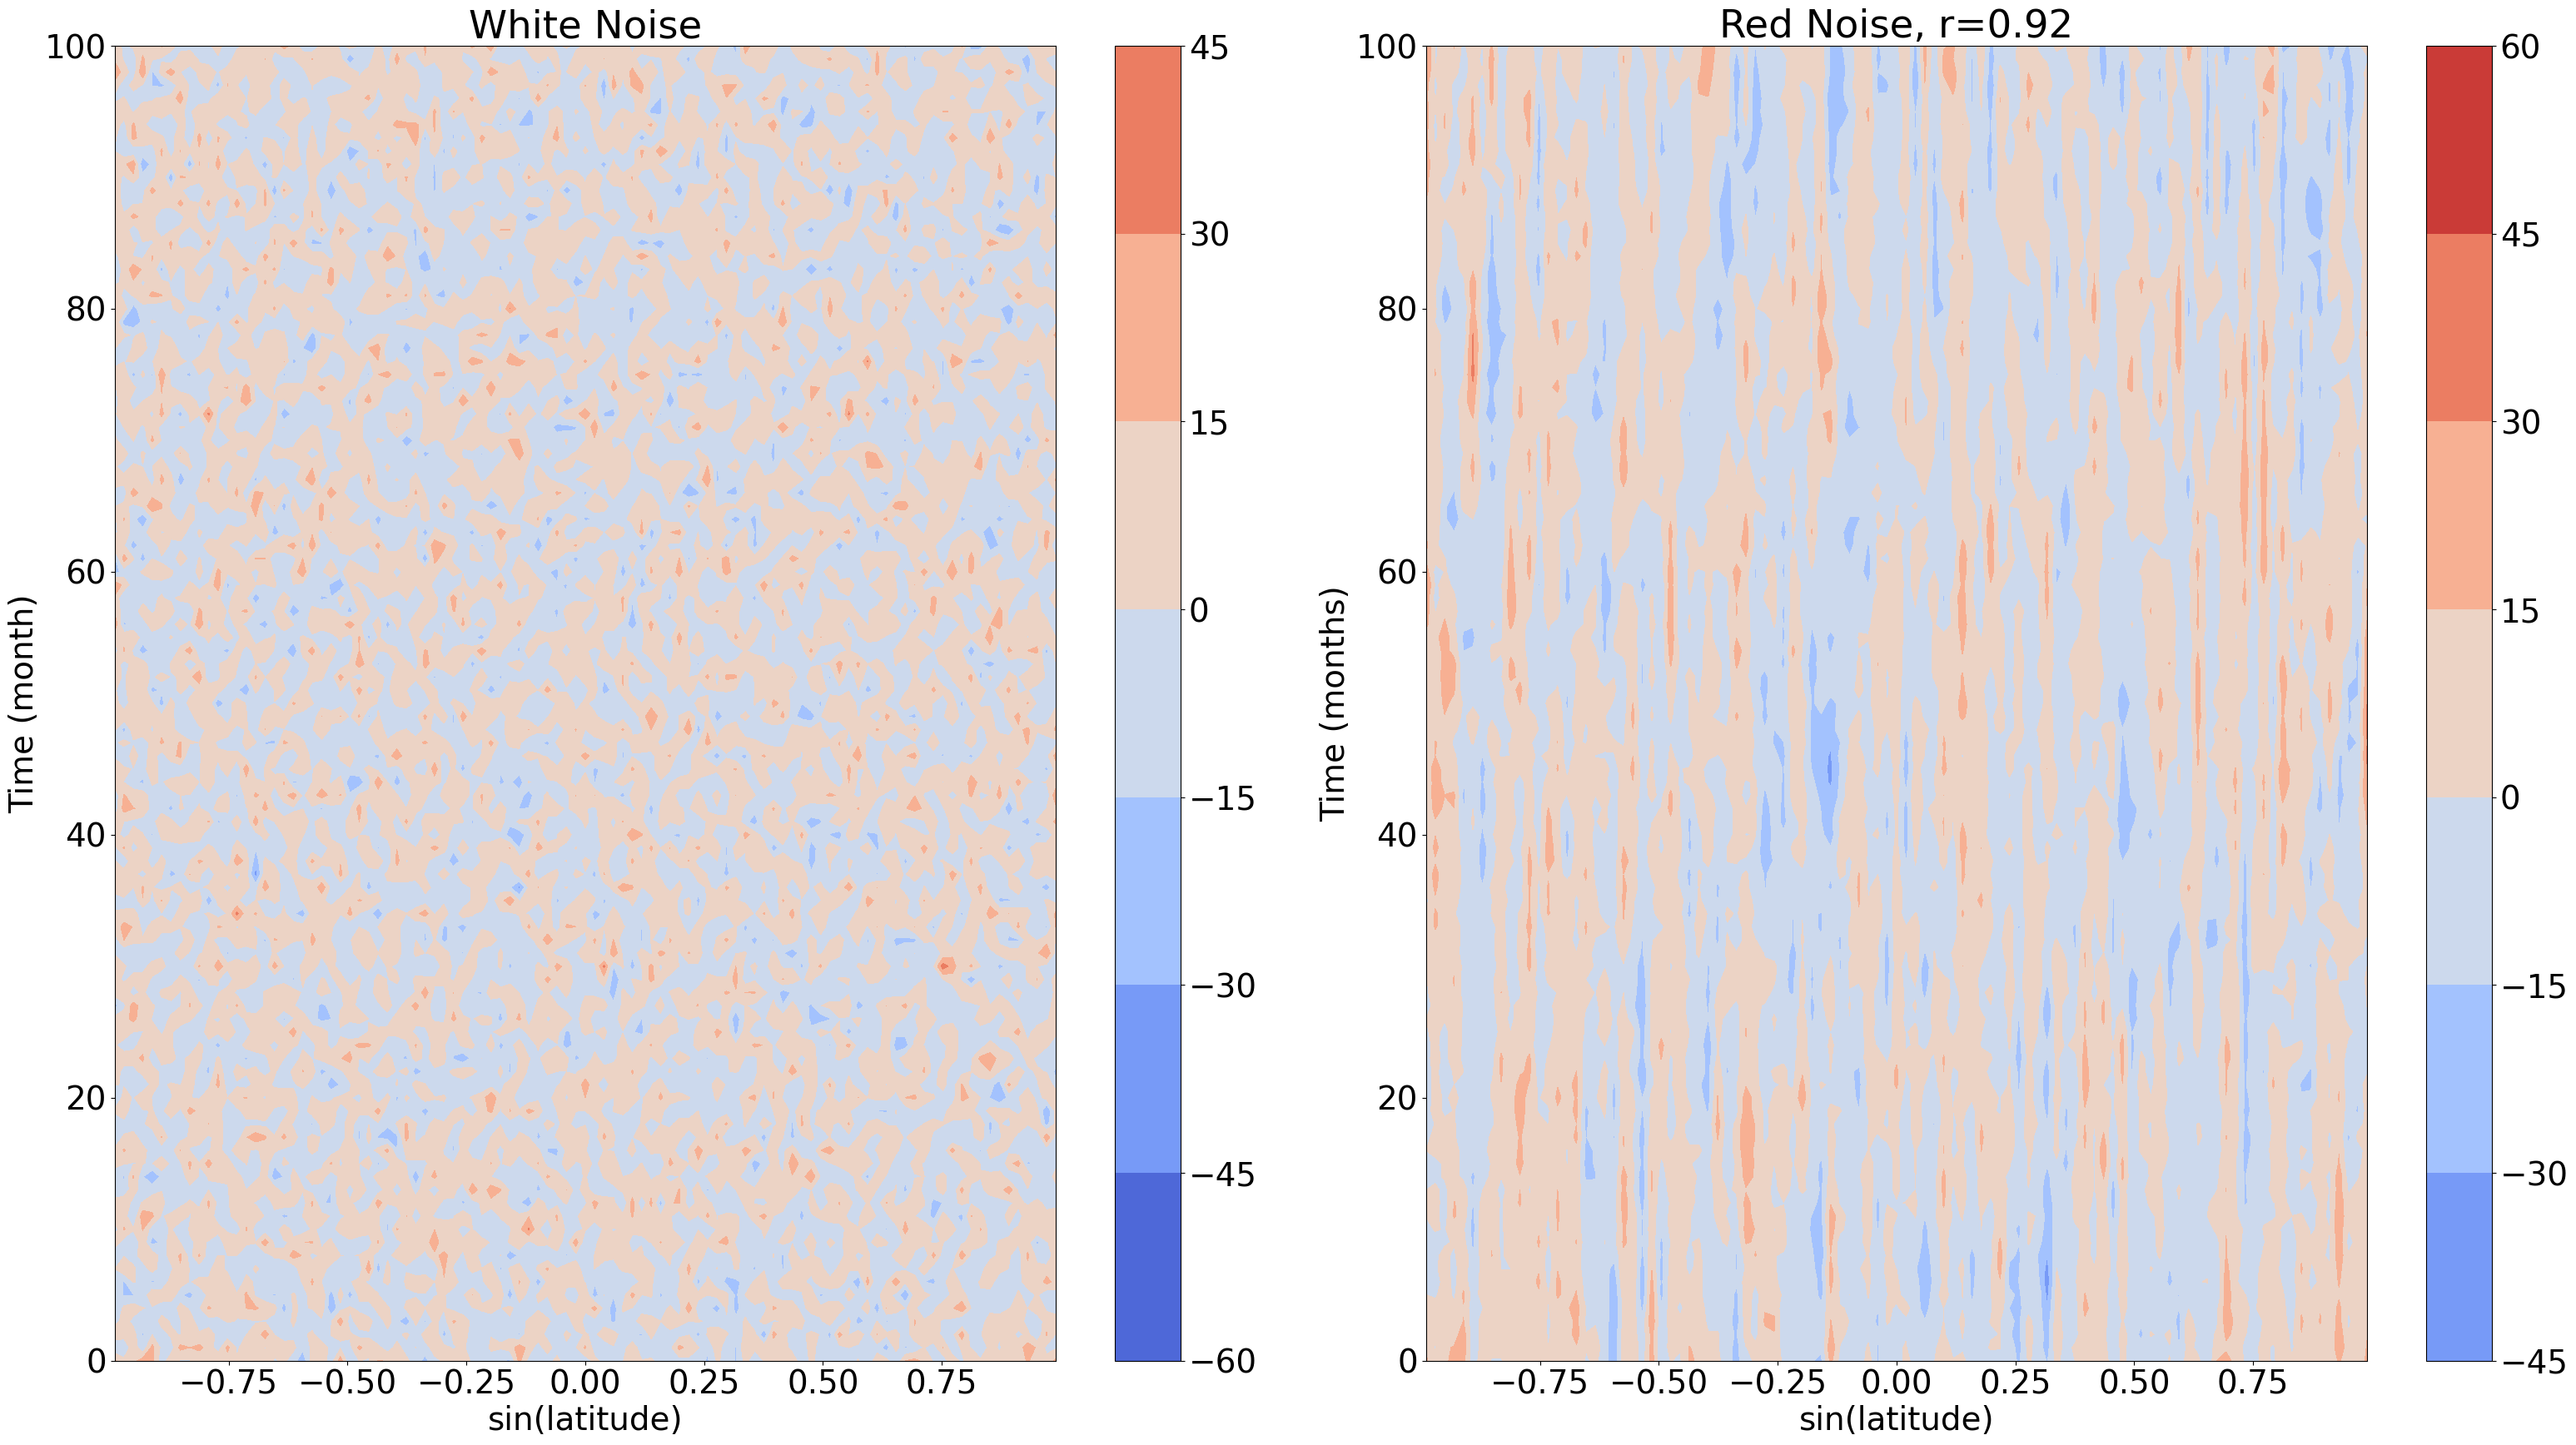

In [329]:
# Choose a random seed to get repeatable simulations
np.random.seed(noise_seed)
print(f"Random Noise Seed: {noise_seed} \n")

# Create a monthly time array 
months = np.arange(n_months)

# Generate white noise at each month and latitude point
white_noise = noise_amplitude*np.random.normal(0, 1, size=(n_months, n_longitude))

# Calculate red noise from white noise
# red_noise_e_folding_time = 24*month_step
red_noise_autocorrelation = np.exp(-month_step/red_noise_e_folding_time)
red_noise = np.empty_like(white_noise)
red_noise[0] = white_noise[0]
for i in range(len(months)-1):
    red_noise[i+1] = (
        red_noise_autocorrelation*red_noise[i] 
        + np.sqrt((1-red_noise_autocorrelation**2))*white_noise[i+1]
    )
    
# white_noise = white_noise[::month_step]
# red_noise = red_noise[::month_step]

# Red noise that grows with time
# growing_red_noise = np.empty_like(white_noise)
# growing_red_noise[0] = white_noise[0]
# for i in range(len(months)-1):
#     growing_red_noise[i+1] = (5/(1+np.exp(-0.001*i)))
#         + (r*growing_red_noise[i] + np.sqrt((1-r**2))*white_noise[i+1])
    
# Set noise to be used in simulation
if noise_color == 'no':
    noise = np.zeros_like(white_noise)
elif noise_color == 'white':
    noise = white_noise
elif noise_color == 'red':
    noise = red_noise
    
# Plot generated noise as a function of month and latitude
plt.style.use('default')
plt.rcParams.update({'font.size':28})
[fig, ax] = plt.subplots(1,2, figsize=(32,18))
im0 = ax[0].contourf(
    sine_latitude, 
    months, 
    white_noise, 
    cmap='coolwarm', 
    norm=colors.CenteredNorm()
)

ax[0].set_title('White Noise')
ax[0].set_xlabel('sin(latitude)')
ax[0].set_ylabel('Time (month)')
ax[0].set_ylim(0,100)
fig.colorbar(im0 ,ax=ax[0])

im1 = ax[1].contourf(
    sine_latitude, 
    months, 
    red_noise, 
    cmap='coolwarm', 
    norm=colors.CenteredNorm()
)
ax[1].set_title(f'Red Noise, r={red_noise_autocorrelation:0.2f}')
ax[1].set_xlabel('sin(latitude)')
ax[1].set_ylabel('Time (months)')
ax[1].set_ylim(0,100)
fig.colorbar(im1 ,ax=ax[1])

plt.tight_layout()
plt.show()

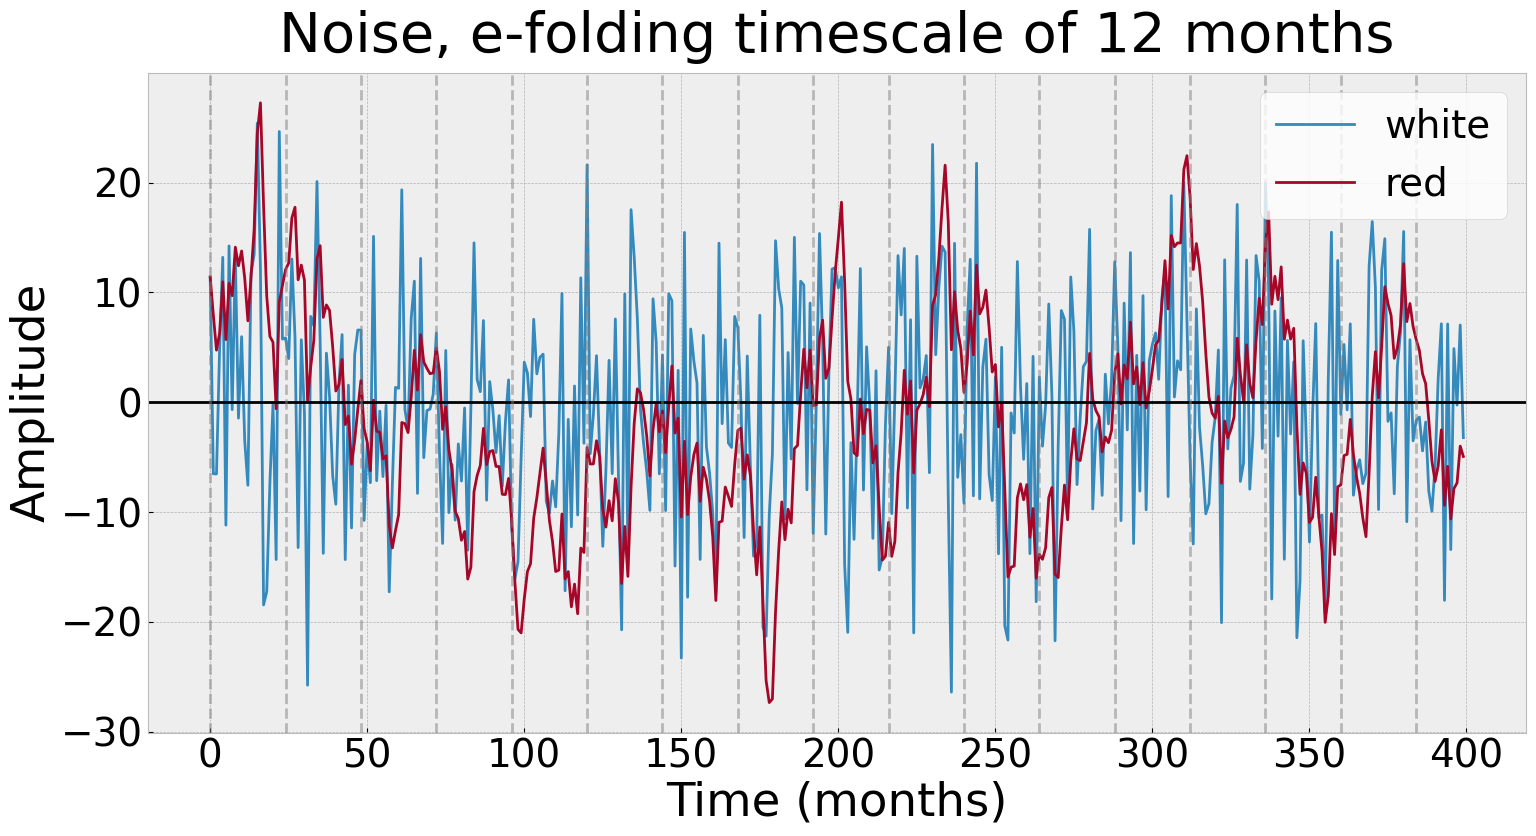

In [330]:
plt.style.use('bmh')
[fig, ax] = plt.subplots(figsize=(16,9))
ax.set_title(f'Noise, e-folding timescale of {12} months', pad=15)
ax.plot(months[:400], white_noise[:400,144//2], label='white')
ax.plot(months[:400], red_noise[:400,144//2], label='red')
ax.axhline(y=0, color='k')
for i in range(0,400,24):
    ax.axvline(x=i, ls='--', color='gray', alpha=0.5)
    
ax.set_xlabel("Time (months)")
ax.set_ylabel('Amplitude')
ax.legend(loc='upper right', facecolor='white')
plt.tight_layout()
plt.show()


# Run Simulation

In [331]:
# Initialize arrays to save output data
save_time = np.arange(n_saves)
temperature_save = np.empty((n_saves, n_longitude))
forcing_save = np.empty((n_saves, n_longitude))

In [332]:
#set up inital T profile 
temperature = 0.5*(1-sine_latitude**2)
Tinit=temperature
Tglob = np.mean(Tinit)

# Timestepping loop
for j in range(0, n_iterations-1):
   
    # Keep track of simulation
    if (j % year_step) == 0: 
        print(f"Simulation year: {j/year_step+1:0.0f}/{n_years}", end='\r')
    
    # Saturation vapor pressure
    saturation_vapor_pressure = e0*np.exp(a*temperature/(b+temperature))

    # spec. hum, and theta_e
    #q=q(:); # here T is in oC. q is g kg-1
    specific_humidity = gas_constant_ratio*relative_humidity*(
        saturation_vapor_pressure/surface_pressure
    )
    
    # Calculate moist static energy in energy units
    moist_static_energy = (
        specific_heat_dry_air*(temperature+273.15) 
        + latent_heat*specific_humidity
    )

    # Convert MSE into temperature units
    moist_static_energy_K = moist_static_energy/specific_heat_dry_air
    
    # Calculate net incoming shortwave radiation:
    albedo = albedo_no_ice*np.ones_like((sine_latitude))
    albedo[temperature < -10] = albedo_ice
    
    incoming_shortwave_radiation = solar_constant*(1-0.241*(3*sine_latitude**2-1))*(1-albedo)
    
    # Calculate net outgoing longwave radiation (OLR)
    outgoing_longwave_radiation = A + B*temperature
    
    # Calculate atmopsheric heat transport (AHT)
    atmospheric_heat_transport = np.matmul(diffusivity_matrix, moist_static_energy_K)
    
    # Add noise once every month
    if (j % month_step) == 0: 
        forcing_noise = noise[(j-1)//month_step]
        
    # Diffuse moist static energy 
    temperature_change = time_step/heat_capacity_land*(
        (incoming_shortwave_radiation + forcing_noise)
        - outgoing_longwave_radiation
        + atmospheric_heat_transport
    )

    # Save temperature and radiative forcing 
    if (j % save_step) == 0: 
        temperature_save[j//save_step] = temperature
        forcing_save[j//save_step] = (
            incoming_shortwave_radiation - outgoing_longwave_radiation
        )

    # Calculate new temperature based on energy imbalance
    temperature = temperature + temperature_change
    
#     # Check to see if global mean energy budget has converged:   
#     Fglob=np.mean(incoming_shortwave_radiation - A - (B*temperature))
    
#     if np.absolute(Fglob) < 0.001: #if (abs(Fglob) < 0.001), break; end
#         break 
        
print("\nSimulation complete") 

Simulation year: 300/300
Simulation complete


# Save Outputs

In [333]:
if save_output == True:
    # Create an xarray DataArray of the temperature
    temperature_output = xr.DataArray(
        temperature_save,
        coords=[save_time, latitude], 
        dims=['time', 'lat']
                           )
    temperature_output = temperature_output.rename('T')
    temperature_output.attrs['units'] = 'degC'
    temperature_output.attrs['long_name'] = (f'Temperature with {noise_color} noise')
    temperature_output['time'].attrs['units'] = f'{save_frequency}'
    
    # Create an xarray DataArray of the radiative forcing
    forcing_output = xr.DataArray(
        forcing_save, 
        coords=[save_time, latitude],
        dims=['time', 'lat']
                                 )
    forcing_output = forcing_output.rename('Src-Snk')
    forcing_output.attrs['units'] = 'W m^-2'
    forcing_output.attrs['long_name'] = (f'Net Radiative Forcing')
    forcing_output['time'].attrs['units'] = f'{save_frequency}'

    # Merge two DataArrays into a single Dataset
    output = xr.merge([temperature_output, forcing_output], combine_attrs='drop_conflicts')

    # Save output to NetCDF
    save_directory = 'data/'
    # file_name = (f'simulation-output_{climatology}_{noise_color}-noise_{n_years}-years_saved-{save_frequency}')
    file_name = fr'output_{climatology}_climatology_{n_years}_years_12_month_{noise_color}_noise'
    print(f"File name: {file_name:s}") 
    output.to_netcdf(save_directory + file_name + '.nc')
    output.close()

File name: output_warmed_climatology_300_years_12_month_red_noise


In [278]:
print(f"Global Mean Temperature {np.mean(temperature):0.1f}°C")

# Calculate energy divergence
flux_divergence = -np.matmul(diffusivity_matrix, moist_static_energy_K)
moist_static_energy = moist_static_energy_K*specific_heat_dry_air

Global Mean Temperature 16.7°C


# Plot Results

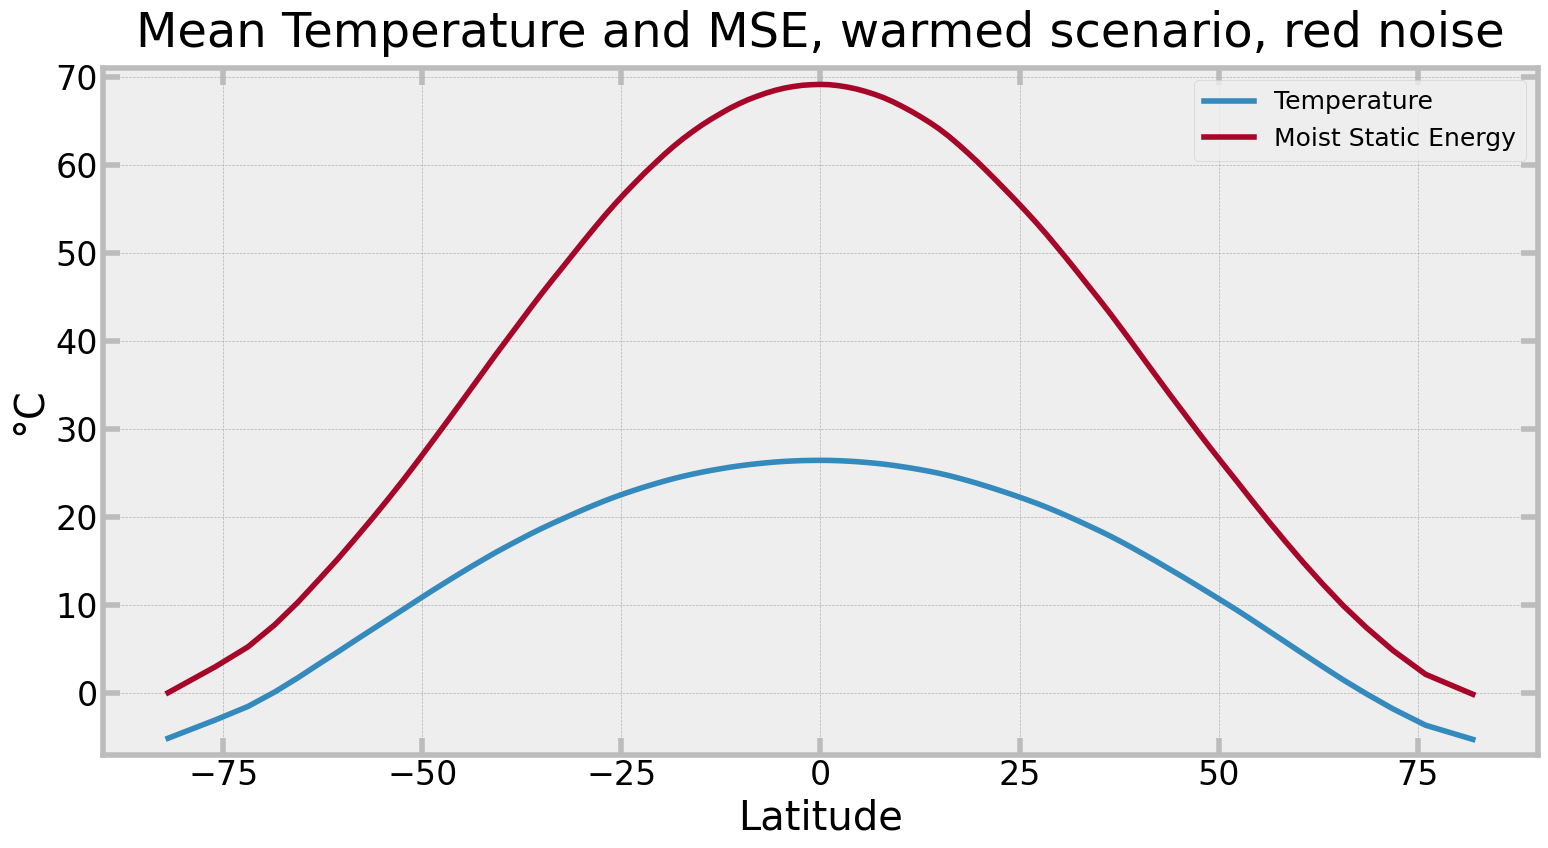

In [334]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':24})

[fig, ax] = plt.subplots(1, 1, figsize=(16,9))

# ax.set_title('Time-Mean Temperature and Moist Static Energy', pad=15)
ax.set_title(f'Mean Temperature and MSE, {climatology} scenario, {noise_color} noise', pad=15)
ax.plot(latitude, temperature, linewidth=4, label='Temperature')
ax.plot(latitude, moist_static_energy_K-273.15, linewidth=4, label='Moist Static Energy')

ax.set_ylim(
    np.floor(np.min(temperature))-1,
    np.ceil(np.max(moist_static_energy_K-273.15))+1
)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)

ax.tick_params(
    axis='both', 
    which='major', 
    direction='in',
    color='#bcbcbc', 
    length=12,
    width=4,
    top=True,
    right=True
)

ax.set_xlabel('Latitude')
ax.set_ylabel('°C')
ax.legend(loc='upper right', fontsize=18)

plt.tight_layout()
plt.show()

Standard Deviations of Temperature 
Northern Hemisphere:        0.805°C
Southern Hemisphere:        0.835°C
Tropics:                    0.554°C


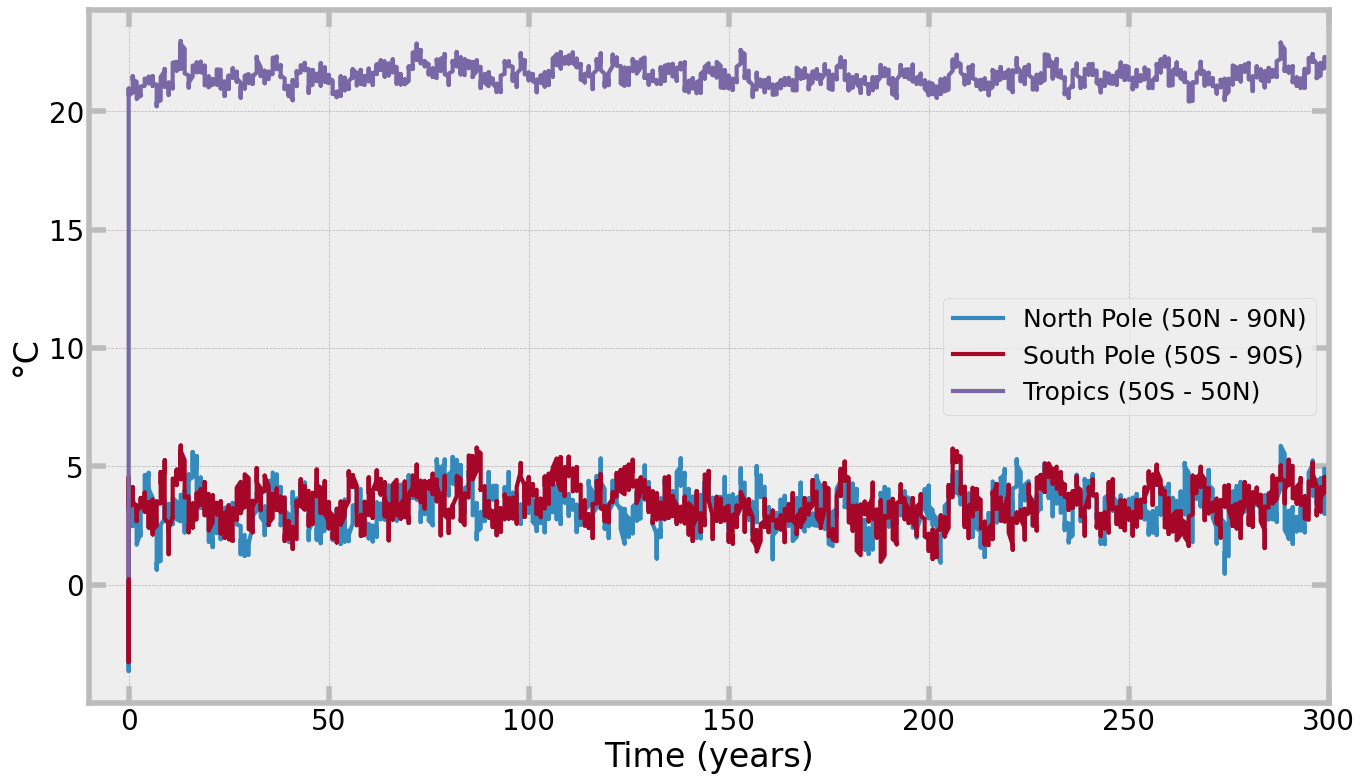

In [336]:
# Average temperature over specified regions
T_SH = np.average(
    temperature_save[:, :11], 
    axis=1, 
    weights=np.cos(np.pi*latitude[:11]/180)
)
T_NH = np.average(
    temperature_save[:, -11:], 
    axis=1, 
    weights=np.cos(np.pi*latitude[-11:]/180)
)
T_Tropics = np.average(
    temperature_save[:, 11:-11],
    axis=1, 
    weights=np.cos(np.pi*latitude[11:-11]/180)
)

# Plot temperature change over time in each region
plt.style.use('bmh')
plt.rcParams.update({'font.size':20})
[fig, ax] = plt.subplots(figsize=(16,9))
# ax.set_title(f'Temperature over time, {climatology} scenario, {noise_color} noise', pad=15)
ax.plot(save_time//12, T_NH, lw=3, label="North Pole (50N - 90N)")
ax.plot(save_time//12, T_SH, lw=3, label="South Pole (50S - 90S)")
ax.plot(save_time//12, T_Tropics, lw=3, label="Tropics (50S - 50N)") # I KNOW, this goes into midtropics :/ 
ax.legend(loc='best', fontsize=18)
# ax.set_xlabel(f"Time ({save_frequency:s})")
ax.set_xlabel('Time (years)')
ax.set_ylabel("°C")
plt.xlim(-10,300)
# plt.gca().set_aspect(300)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)

ax.tick_params(
    axis='both', 
    which='major', 
    direction='in',
    color='#bcbcbc', 
    length=12,
    width=4,
    top=True,
    right=True
)

# Calculate standard deviation of each time series
print(f"{'Standard Deviations of Temperature':^35s}")
print(f"{'':{'='}^35s}")
print(f"{'Northern Hemisphere:':25s} {np.std(T_NH):>7.3f}°C")
print(f"{'Southern Hemisphere:':25s} {np.std(T_SH):>7.3f}°C")
print(f"{'Tropics:':25s} {np.std(T_Tropics):>7.3f}°C")
# print("Already we see way more temperature variability in poles! \n")

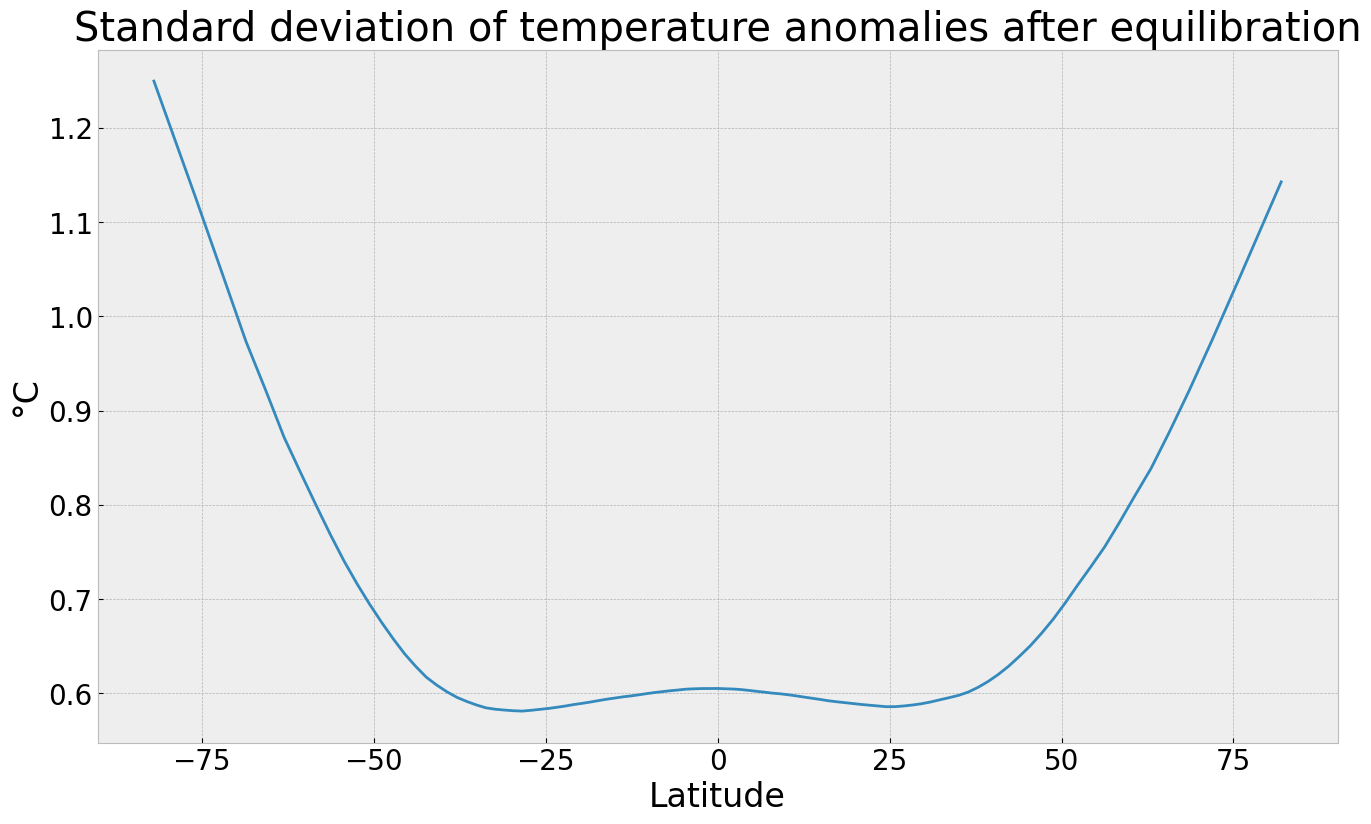

In [337]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(16,9))
plt.title(f'Standard deviation of temperature anomalies after equilibration')
plt.plot(latitude, np.std(temperature_save, axis=0))
plt.xlabel("Latitude")
plt.ylabel("°C")
# plt.xlim(20,120)
# plt.gca().set_aspect(300)
plt.show()

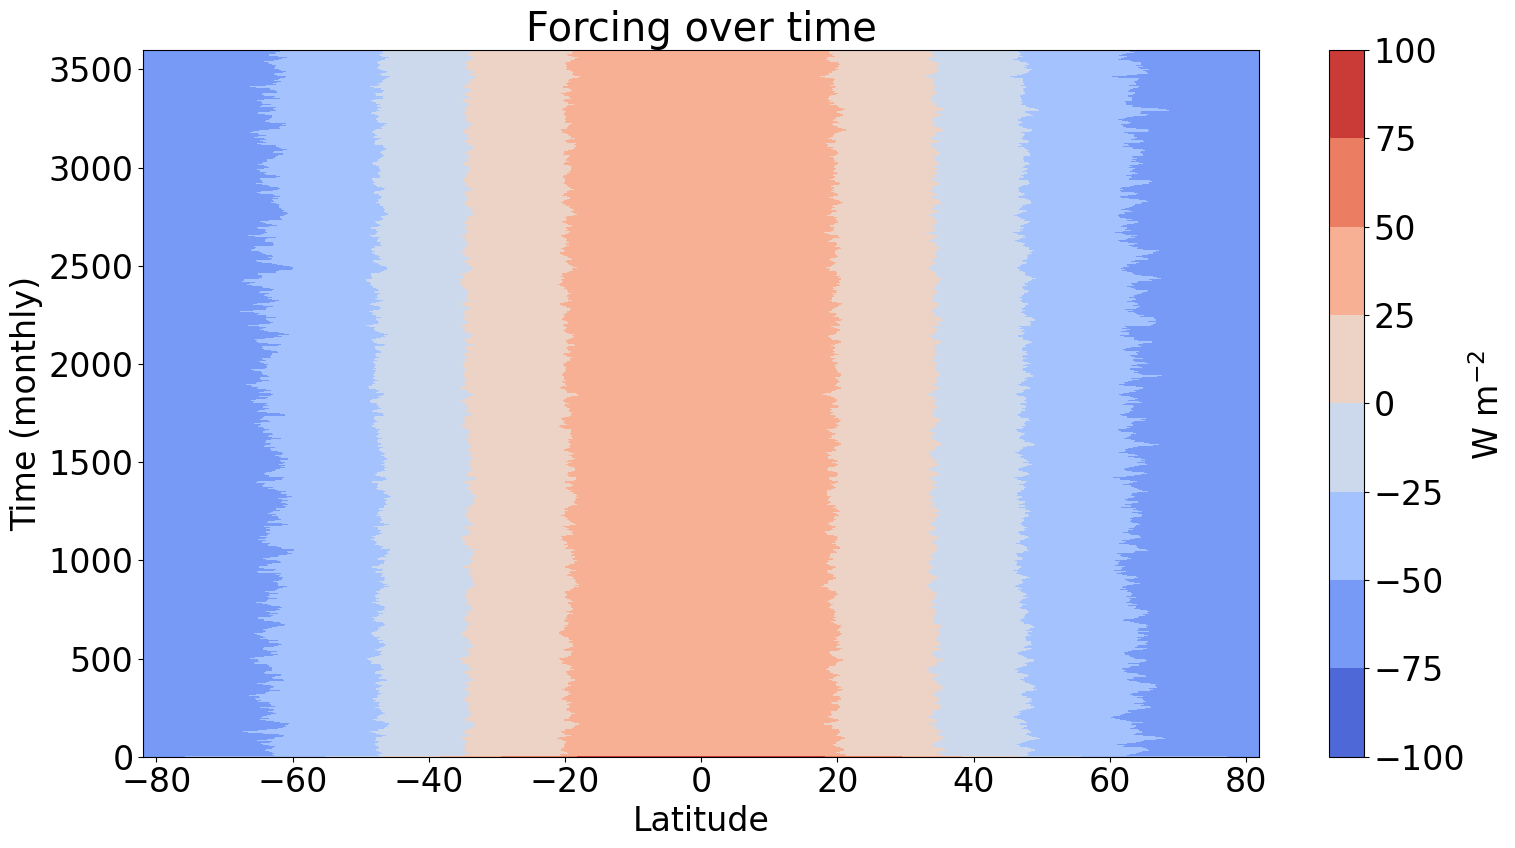

In [338]:
plt.style.use('default')
plt.rcParams.update({'font.size':24})
[fig, ax] = plt.subplots(figsize=(16,9))
im = ax.contourf(latitude, save_time, forcing_save, cmap='coolwarm', norm=colors.CenteredNorm())
ax.set_title('Forcing over time')
ax.set_xlabel('Latitude')
ax.set_ylabel(f'Time ({save_frequency:s})')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'W m$^{-2}$ ')
plt.tight_layout()
plt.show()

# Test Statistical Significance

## Standardize time series

In [282]:
def standardize_time_series(time_series):
    return (time_series - np.mean(time_series))/np.std(time_series)

In [283]:
# Standardize time series before calculating autocorrelation
T_NH_standardized = standardize_time_series(T_NH)
T_SH_standardized = standardize_time_series(T_SH)
T_Tropics_standardized = standardize_time_series(T_Tropics)

## Estimate autocorrelation and degrees of freedom

In [284]:
# Northern Hemisphere
autocorrelation_NH = np.sum(
            T_NH_standardized[1:] * T_NH_standardized[:-1]
        ) / (len(T_NH_standardized)-1)

degrees_of_freedom_NH = len(T_NH_standardized)*(
        1. - np.mean(autocorrelation_NH)**2
    ) / (1. + np.mean(autocorrelation_NH)**2)

# Southern Hemisphere
autocorrelation_SH = np.sum(
            T_SH_standardized[1:] * T_SH_standardized[:-1]
        ) / (len(T_SH_standardized)-1)

degrees_of_freedom_SH = len(T_SH_standardized)*(
        1. - np.mean(autocorrelation_SH)**2
    ) / (1. + np.mean(autocorrelation_SH)**2)

# Tropics
autocorrelation_Tropics = np.sum(
            T_Tropics_standardized[1:] * T_Tropics_standardized[:-1]
        ) / (len(T_Tropics_standardized)-1)

degrees_of_freedom_Tropics = len(T_Tropics_standardized)*(
        1. - np.mean(autocorrelation_Tropics)**2
    ) / (1. + np.mean(autocorrelation_Tropics)**2)

# Print summary table
print(f"{'Time Series Summary Statistics':^89s}")
print(f"{'':{'='}^88}")
print(f"{'|'}{'Region':^24}{'|'}{'Degrees of Freedom':^30}{'|'}{'Autocorrelation':^30}{'|'}")
print(f"{'':{'='}^88}")
print(f"{'|'}{'Northern Hemisphere':^24}{'|'}{degrees_of_freedom_NH:^30.0f}{'|'}{autocorrelation_NH:^30.3f}{'|'}")
print(f"{'|'}{'Southern Hemisphere':^24}{'|'}{degrees_of_freedom_SH:^30.0f}{'|'}{autocorrelation_SH:^30.3f}{'|'}")
print(f"{'|'}{'Tropics':^24}{'|'}{degrees_of_freedom_Tropics:^30.0f}{'|'}{autocorrelation_Tropics:^30.3f}{'|'}")
print(f"{'':{'='}^88}")

                             Time Series Summary Statistics                              
|         Region         |      Degrees of Freedom      |       Autocorrelation        |
|  Northern Hemisphere   |             296              |            0.976             |
|  Southern Hemisphere   |             287              |            0.976             |
|        Tropics         |             1763             |            0.862             |


## Perform F-statistic test

In [285]:
f_critical_NH_SH = f.ppf(p_critical, degrees_of_freedom_NH, degrees_of_freedom_SH)
f_critical_NH_Tropics = f.ppf(p_critical, degrees_of_freedom_NH, degrees_of_freedom_Tropics)
f_critical_SH_Tropics = f.ppf(p_critical, degrees_of_freedom_SH, degrees_of_freedom_Tropics)

f_NH_SH = np.std(T_NH)**2/np.std(T_SH)**2
f_NH_Tropics = np.std(T_NH)**2/np.std(T_Tropics)**2
f_SH_Tropics = np.std(T_SH)**2/np.std(T_Tropics)**2

print(f"{'Statistical Significance Test Results':^66s}")
print(f"{'':{'='}^66s}")
print(f"{'|'}{'Region':^18s}{'|'}{'F Statistic':^22s}{'|'}{'F Critical':^22s}{'|'}")
print(f"{'':{'='}^66s}")
print(f'{"|"}{"NH & SH":^18s}{"|"}{f_NH_SH:^22.3f}{"|"}{f_critical_NH_SH:^22.3f}{"|"}')     
print(f'{"|"}{"NH & Tropics":^18s}{"|"}{f_NH_Tropics:^22.3f}{"|"}{f_critical_NH_Tropics:^22.3f}{"|"}')     
print(f'{"|"}{"SH & Tropics":^18s}{"|"}{f_SH_Tropics:^22.3f}{"|"}{f_critical_SH_Tropics:^22.3f}{"|"}')     
print(f"{'':{'='}^66s}")

if f_critical_NH_SH < f_NH_SH:
    print(f"✓  NH variability is statistically larger than " 
          + f"SH variability at the {100*p_critical:0.0f}% confidence level!")
else:
    print(f"X  NH variability is NOT statistically larger than " 
      + f"SH variability at the {100*p_critical:0.0f}% confidence level!")

if f_critical_NH_Tropics < f_NH_Tropics:
    print(f"✓  NH variability is statistically larger than " 
          + f"Tropical variability at the {100*p_critical:0.0f}% confidence level!")

else:
    print(f"X  NH variability is NOT statistically larger than " 
      + f"Tropical variability at the {100*p_critical:0.0f}% confidence level!")
    
if f_critical_SH_Tropics < f_SH_Tropics:
    print(f"✓  SH variability is statistically larger than " 
          + f"Tropical variability at the {100*p_critical:0.0f}% confidence level!")
    
else:
    print(f"X  SH variability is NOT statistically larger than " 
      + f"Tropical variability at the {100*p_critical:0.0f}% confidence level!")

              Statistical Significance Test Results               
|      Region      |     F Statistic      |      F Critical      |
|     NH & SH      |        0.918         |        1.213         |
|   NH & Tropics   |        3.022         |        1.152         |
|   SH & Tropics   |        3.291         |        1.154         |
X  NH variability is NOT statistically larger than SH variability at the 95% confidence level!
✓  NH variability is statistically larger than Tropical variability at the 95% confidence level!
✓  SH variability is statistically larger than Tropical variability at the 95% confidence level!


# Compare results across runs

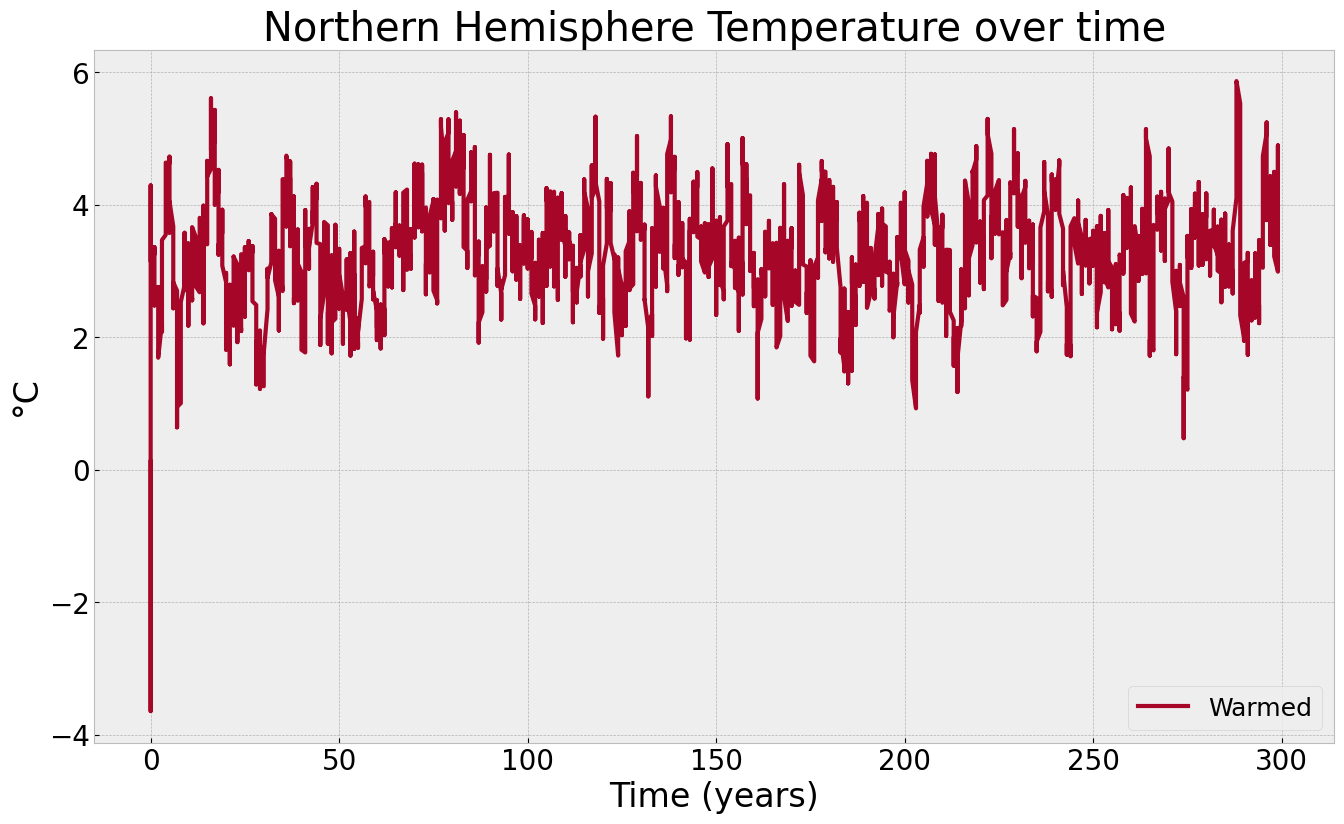

In [347]:
# Load data
# Basic state
# basic_state_data = xr.open_dataset(
#     'data/output_basic_state_climatology_1000_years_24_month_red_noise.nc'
# )
# temperature_basic_state = basic_state_data['T']
# forcing_basic_state = basic_state_data['Src-Snk']

warmed_data = xr.open_dataset(
    'data/output_warmed_climatology_300_years_12_month_red_noise.nc'
)
temperature_warmed = warmed_data['T']
forcing_warmed = warmed_data['Src-Snk']

# cooled_data = xr.open_dataset(
#     'data/output_cooled_climatology_100_years_white_noise.nc'
# )
# temperature_cooled = cooled_data['T']

# Average over the Northern Hemisphere (50°N-90°N)
# temperature_basic_state_NH = np.average(
#     temperature_basic_state[:, -11:],
#     axis=1, 
#     weights=np.cos(np.pi*latitude[-11:]/180)
# )

temperature_warmed_NH = np.average(
    temperature_warmed[:, -11:],
    axis=1, 
    weights=np.cos(np.pi*latitude[-11:]/180)
)


# Average over the Tropics (50°S-50°N)
# temperature_basic_state_Tropics = np.average(
#     temperature_basic_state[:, 11:-11],
#     axis=1, 
#         weights=np.cos(np.pi*latitude[11:-11]/180)
# )

temperature_warmed_Tropics = np.average(
    temperature_warmed[:, 11:-11],
    axis=1, 
    weights=np.cos(np.pi*latitude[11:-11]/180)
)

# Average over the Southern Hemisphere (90°S-50°S) 
# T_NH_cooled = np.average(
# temperature_cooled[:, -11:],
# axis=1, 
# weights=np.cos(np.pi*latitude[-11:]/180))

# T_Tropics_cooled = np.average(
# temperature_cooled[:, 11:-11],
# axis=1, 
#     weights=np.cos(np.pi*latitude[11:-11]/180))

# Plot temperature change over time
plt.style.use('bmh')
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(16,9))
plt.title(f'Northern Hemisphere Temperature over time')
# plt.plot(save_time//12, temperature_basic_state_NH, lw=3, color='#348ABD', label="Basic State")
plt.plot(save_time//12, temperature_warmed_NH, lw=3, color='#A60628', label="Warmed")
# plt.plot(save_time, temperature_cooled, lw=3, color='#7A68A6', label="Cooled")

plt.legend(loc='lower right', fontsize=18)
# plt.xlabel(f"Time ({save_frequency:s})")
plt.xlabel('Time (years)')
plt.ylabel("°C")
plt.show()

Standard Deviation of Temperature
-------------
NH BS 1.45°C
T BS  0.52°C
-------------
NH W  0.80°C
T W   0.55°C


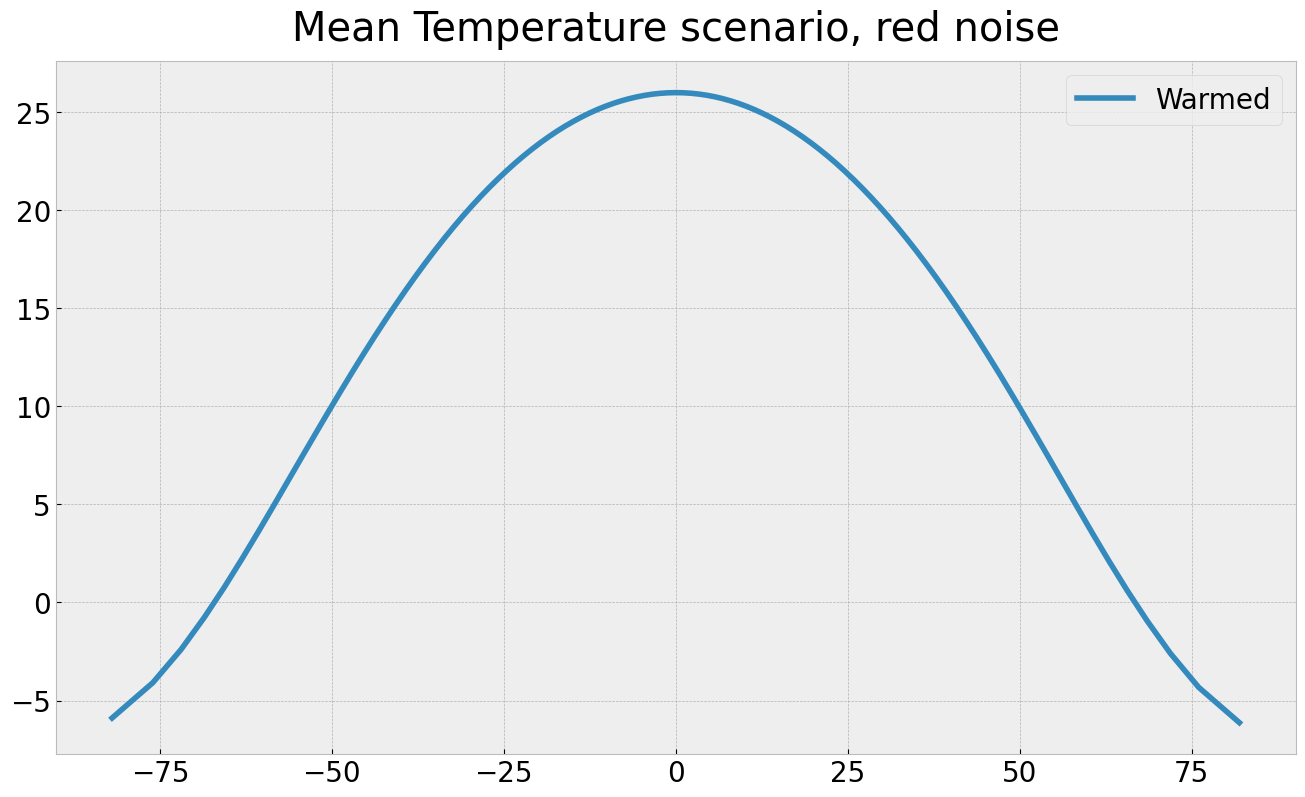

In [348]:
[fig, ax] = plt.subplots(1, 1, figsize=(16,9))

# ax.set_title('Time-Mean Temperature and Moist Static Energy', pad=15)
ax.set_title(f'Mean Temperature scenario, {noise_color} noise', pad=15)
# ax.plot(latitude, np.mean(temperature_basic_state, axis=0), linewidth=4, label='Basic State')
ax.plot(latitude, np.mean(temperature_warmed, axis=0), linewidth=4, label='Warmed')
ax.legend()


print('Standard Deviation of Temperature')
print('-------------')
print(f"NH BS {np.std(temperature_basic_state_NH):>4.2f}°C")
print(f"T BS  {np.std(temperature_basic_state_Tropics):>4.2f}°C")
print("-------------")
print(f"NH W  {np.std(temperature_warmed_NH):>4.2f}°C")
print(f"T W   {np.std(temperature_warmed_Tropics):>4.2f}°C")
# print("-------------")
# print(f"NH C  {np.std(T_NH_cooled):>4.2f}°C")
# print(f"T C   {np.std(T_Tropics_cooled):>4.2f}°C")

# print(np.std(T_Tropics_basic_state))
# print(np.std(T_NH_warmed))
# print(np.std(T_Tropics_warmed))   
# print(np.std(T_NH_cooled))
# print(np.std(T_Tropics_cooled))   
    
# # Northern Hemisphere
# autocorrelation_NH = np.sum(
#             T_NH_standardized[1:] * T_NH_standardized[:-1]
#         ) / (len(T_NH_standardized)-1)

# degrees_of_freedom_NH = len(T_NH_standardized)*(
#         1. - np.mean(autocorrelation_NH)**2
#     ) / (1. + np.mean(autocorrelation_NH)**2)

# # Southern Hemisphere
# autocorrelation_SH = np.sum(
#             T_SH_standardized[1:] * T_SH_standardized[:-1]
#         ) / (len(T_SH_standardized)-1)

# degrees_of_freedom_SH = len(T_SH_standardized)*(
#         1. - np.mean(autocorrelation_SH)**2
#     ) / (1. + np.mean(autocorrelation_SH)**2)

# # Tropics
# autocorrelation_Tropics = np.sum(
#             T_Tropics_standardized[1:] * T_Tropics_standardized[:-1]
#         ) / (len(T_Tropics_standardized)-1)

# degrees_of_freedom_Tropics = len(T_Tropics_standardized)*(
#         1. - np.mean(autocorrelation_Tropics)**2
#     ) / (1. + np.mean(autocorrelation_Tropics)**2)

# # Print summary table
# print(f"{'Time Series Summary Statistics':^89s}")
# print(f"{'':{'='}^88}")
# print(f"{'|'}{'Region':^24}{'|'}{'Degrees of Freedom':^30}{'|'}{'Autocorrelation':^30}{'|'}")
# print(f"{'':{'='}^88}")
# print(f"{'|'}{'Northern Hemisphere':^24}{'|'}{degrees_of_freedom_NH:^30.0f}{'|'}{autocorrelation_NH:^30.3f}{'|'}")
# print(f"{'|'}{'Southern Hemisphere':^24}{'|'}{degrees_of_freedom_SH:^30.0f}{'|'}{autocorrelation_SH:^30.3f}{'|'}")
# print(f"{'|'}{'Tropics':^24}{'|'}{degrees_of_freedom_Tropics:^30.0f}{'|'}{autocorrelation_Tropics:^30.3f}{'|'}")
# print(f"{'':{'='}^88}")

# Power Spectra

In [343]:
def calculate_red_spectrum(frequency, autocorrelation):
    red_spectrum = (1-autocorrelation**2)/(1-(2*autocorrelation*np.cos(frequency*2*np.pi))+autocorrelation**2)
    return red_spectrum

In [344]:
def compute_power_spectrum(temperature, window_size):
    # Calculate raw spectra
    [
        frequency,
        power_spectrum 
    ] = signal.welch(
        temperature,
        nperseg=window_size,
        noverlap=window_size//2, 
        detrend='linear',
        fs=1
    )
    power_spectrum_normalized = power_spectrum/np.mean(power_spectrum)

    # Fit red noise spectrum to data
    [parameters, covariance] = curve_fit(
        calculate_red_spectrum, 
        frequency, 
        power_spectrum_normalized,
        p0=(0.5)
    )

    red_spectrum_fit = calculate_red_spectrum(
        frequency, 
        parameters[0]
    )
    
    return frequency, power_spectrum_normalized, red_spectrum_fit

In [346]:
# Specify window size
window_size = 32

# # Power spectra of basic state NH
# [
#     temperature_basic_state_NH_frequency,
#     temperature_basic_state_NH_power_spectrum_normalized,
#     temperature_basic_state_NH_red_spectrum_fit
# ] = compute_power_spectrum(temperature_basic_state_NH[12*50:], window_size=window_size)

# Power spectrum of warmed NH
[
    temperature_warmed_NH_frequency,
    temperature_warmed_NH_power_spectrum_normalized,
    temperature_warmed_NH_red_spectrum_fit
] = compute_power_spectrum(temperature_warmed_NH[12*50:], window_size=window_size)

# # Power spectra of basic state Tropics
# [
#     temperature_basic_state_Tropics_frequency,
#     temperature_basic_state_Tropics_power_spectrum_normalized,
#     temperature_basic_state_Tropics_red_spectrum_fit
# ] = compute_power_spectrum(temperature_basic_state_Tropics[12*50:], window_size=window_size)

# Power spectrum of warmed Tropics
[
    temperature_warmed_Tropics_frequency,
    temperature_warmed_Tropics_power_spectrum_normalized,
    temperature_warmed_Tropics_red_spectrum_fit
] = compute_power_spectrum(temperature_warmed_Tropics[12*50:], window_size=window_size)


# Estimate degrees of freedom
degrees_of_freedom_numerator = 2*len(latitude)/window_size
degrees_of_freedom_denominator = len(latitude)//2
f_critical = scipy.stats.f.ppf(p_critical, degrees_of_freedom_numerator, degrees_of_freedom_denominator)

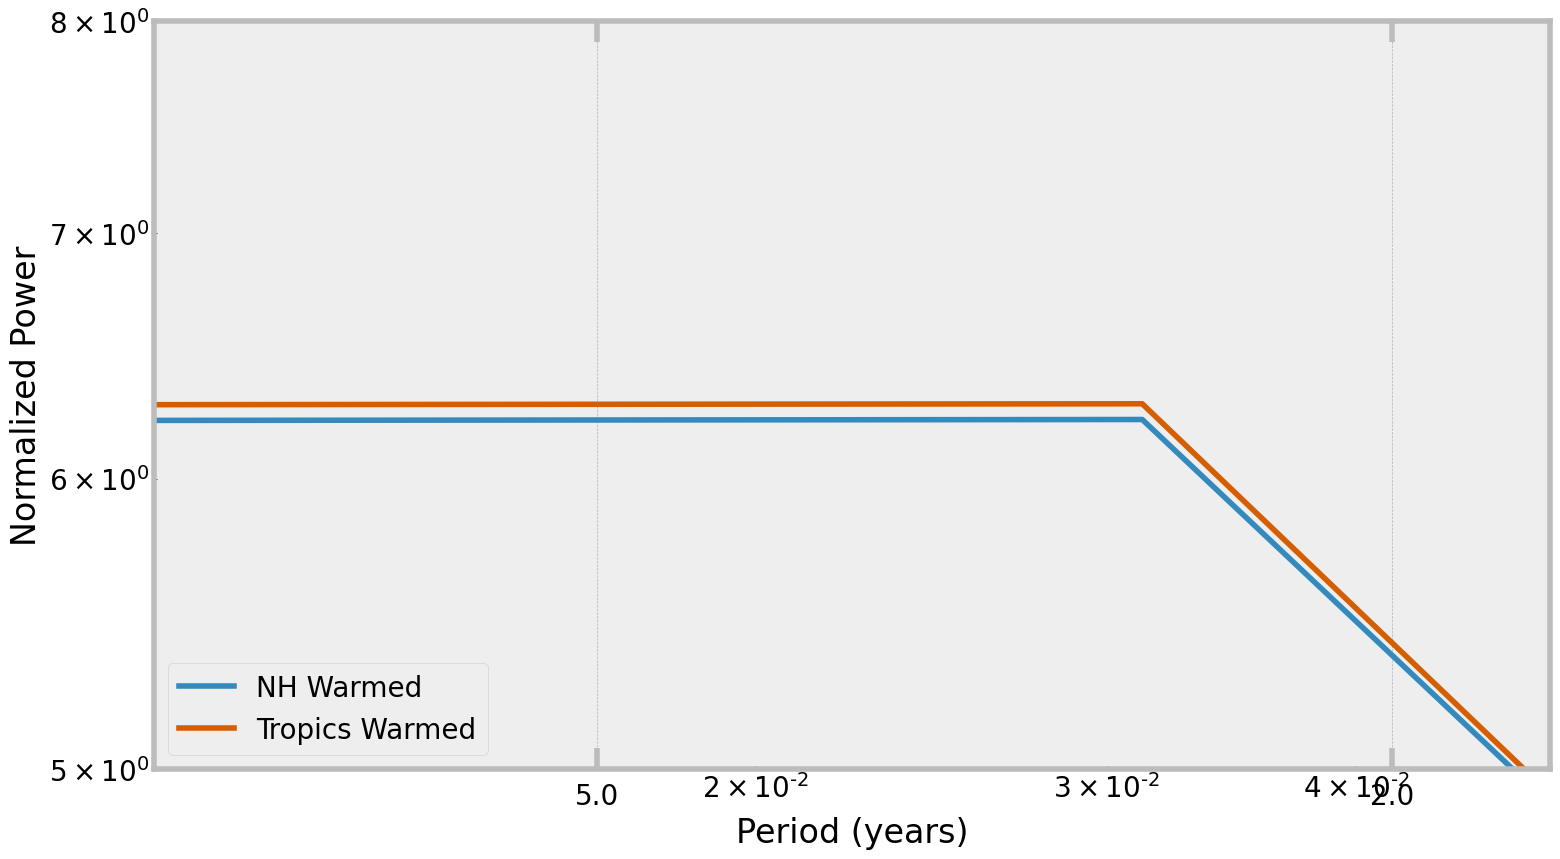

In [352]:
# periods = np.array([1200, 768, 384, 192, 96, 48, 24, 12, 6, 3, 2])
periods = np.array([1000, 500, 200, 100, 50, 20, 10, 5, 2, 1, 0.5, 0.25])
frequency_from_period = 1/(12*periods)

plt.style.use('bmh')
[fig, ax] = plt.subplots(
    1,
    1,
    figsize=(16,9))

# ax.set_title(f'Power spectra of Temperature', pad=15)

# Plot Temperature Power Spectrum
# ax.loglog(
#     temperature_basic_state_NH_frequency, 
#     temperature_basic_state_NH_power_spectrum_normalized, 
#     lw=4,
#     label='NH Basic State',
#     color = '#7A68A6'
# )

ax.loglog(
    temperature_warmed_NH_frequency, 
    temperature_warmed_NH_power_spectrum_normalized, 
    lw=4,
    label='NH Warmed',
    color='#348ABD'
)

# ax.loglog(
#     temperature_basic_state_Tropics_frequency, 
#     temperature_basic_state_Tropics_power_spectrum_normalized, 
#     lw=4,
#     label='Tropics Basic State',
#     color = '#467821'
# )

ax.loglog(
    temperature_warmed_Tropics_frequency, 
    temperature_warmed_Tropics_power_spectrum_normalized, 
    lw=4,
    label='Tropics Warmed',
    color='#D55E00'
)


# ax.loglog(
#     frequency, 
#     temperature_warmed_NH_red_spectrum_fit, 
#     color='#A60628', 
#     lw=4,
#     label='Red Fit'
# )

# ax.loglog(
#     frequency, 
#     f_critical*temperature_warmed_NH_red_spectrum_fit, 
#     color='#A60628', 
#     lw=4,
#     ls='--',
#     label='95% Level'
# )

for edge in ['top','bottom','left','right']:
    ax.spines[edge].set_linewidth(4)
ax.tick_params(
    which='major',
    axis='both',
    direction='in',
    top=True,
    right=True,
    width=4,
    length=15,
    color='#bcbcbc',
    pad=10
)   

ax.set_xticks(ticks = frequency_from_period)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(periods))
# ax.set_xlim(1/(12*5), 1/(12*(2)))
ax.set_xlim(1/100, 1/20)
ax.set_ylim(5, 8)

ax.set_xlabel(r'Period (years)')
ax.set_ylabel('Normalized Power')


ax.legend(loc='lower left')
plt.tight_layout()
plt.show()